In [1]:
import zipfile
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import tz
from time import time
import pickle
import scipy.stats as st

os.chdir('/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard _repo/CS2-flights-delay-REPO')

# pd.set_option('display.max_rows', 130)
# pd.set_option('display.width', 200)

# Loading timezones for IATA codes of airports
IATAtz_df = pd.read_csv('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', 
                        sep = '\t', 
                        index_col=0, 
                        header=None)

# Dictionary with IATA codes as keys and timezones as values
IATAtz = IATAtz_df.to_dict('dict')[1]
del(IATAtz_df)

# List of dates of start/end of DST
DST = pd.to_datetime(['2014-03-09', '2014-11-02', '2015-03-08', '2015-11-01', 
       '2016-03-13', '2016-11-06', '2017-03-12', '2017-11-05', 
       '2018-03-11', '2018-11-04'])


In [2]:
fields_to_load = {
    # 'Year':                 np.int16,               
    # 'Quarter':              np.int8,                
    # 'Month':                np.int8,                
    # 'DayofMonth':           np.int8,
    # 'DayOfWeek':            np.int8,
    'FlightDate':           'str',
    'Reporting_Airline':    'category',
    'Flight_Number_Reporting_Airline':  np.int16,
    # 'OriginAirportID':      'category',
    'Origin':               'category',
    # 'DestAirportID':        'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              'float32',
    'DepDelay':             'float32',
    'DepartureDelayGroups': 'category',
    'DepTimeBlk':           'category',
    'CRSArrTime':           np.int16,
    'ArrTime':              'float32',
    'ArrDelay':             'float32',
    # 'Distance':             'float32',
    'ArrivalDelayGroups':   'category',
    'ArrTimeBlk':           'category',
    'Cancelled':            np.int8,        # boolean
    'CancellationCode':     'category',
    'Diverted':             np.int8,        # boolean
    'CarrierDelay':         'float32',
    'WeatherDelay':         'float32',
    'NASDelay':             'float32',
    'SecurityDelay':        'float32',
    'LateAircraftDelay':    'float32',
    'CRSElapsedTime':       'float32',
    'ActualElapsedTime':    'float32',
    'AirTime':              'float32',
    'DivReachedDest':       'float32',      # boolean
    'DivActualElapsedTime': 'float32',
    'DivArrDelay':          'float32'}

In [3]:
# [FUNCTION]

# # Convert Arrival and Departure times (CRS and Actual) to minutes
def time_to_minutes(df):
    return df // 100 * 60 + df % 100

In [4]:
# [FUNCTION]

def get_CRS_datetime(dates, dep_m, arr_m):
    """
    Description
    ------------
    Calculate scheduled(CRS) Departure datetime (timezone naive) based on Flight Date and Departure time (minutes)
    Calculate scheduled(CRS) Arrival datetiem (timezone naive) based on Flight Date and Arrival time (minutes). 
        Arrival time is increased by one day from Fllght Date if the difference between CRS Arrival and Departure time 
        is equal or less than -60 minutes, and decreased by one day if the difference is at least +1380 minutes.

    Parameters:
    ------------
    dates - pandas Series with FlightDate
    dep_m - pandas Seiries with CRS Departure time in minutes 
    arr_m - pandas Seiries with CRS Arrival time in minutes

    Returns:
    ------------
    departure_datetime - CRS Departure datetime (timezone naive) (pd.Series)
    arrival_datetime - CRS Arrival datetime (timezone naive) (pd.Series)
    """

    df = pd.DataFrame() 
    df['departure_datetime'] = pd.to_datetime(dates) + pd.to_timedelta(dep_m, unit='min')

    # Filter for scheduled flights arriving next or privios day
    arr_next_day_filter = arr_m - dep_m  <= -60
    arr_previous_day_filter = arr_m - dep_m  >= 1380

    # For all scheduled flights by default arrival date is eaueal to departure date
    df['arrival_datetime'] = dates

    # Adding one day to the date if flight arrived next day
    df.loc[arr_next_day_filter, 'arrival_datetime'] = df.loc[arr_next_day_filter, 'arrival_datetime'] \
                                                        + datetime.timedelta(1)
    # Adding one day to the date if flight arrived day befor departure day
    df.loc[arr_previous_day_filter, 'arrival_datetime'] = df.loc[arr_previous_day_filter, 'arrival_datetime'] \
                                                        + datetime.timedelta(-1)
    # Finally adding actual arrival time to get actual arrival datetime
    df['arrival_datetime'] = df['arrival_datetime'] + pd.to_timedelta(arr_m, 'm')

    return df['departure_datetime'], df['arrival_datetime']


In [5]:
# [FUNCTION]

def get_Actual_datetime(dates, CRSdep_min, dep_min, arr_min, dep_delay):
    """
    Description
    ------------
    Calculate Actual Departure datetime (timezone naive) based on Flight Date, Departure time (minutes) and Departure 
        delay (minutes)
    Calculate Actual Arrival datetiem (timezone naive) based on Flight Date, Actual Departure date in accordance with 
        Departure delay and Arrival time (minutes). Arrival time is increased by one day from Departure Date if 
        the difference between CRS Arrival and Departure time is equal or less than -60 minutes, and decreased by one day 
        if the difference is at least +1380 minutes.

    Parameters:
    ------------
    dates - FlightDate (pd.Series)
    CRSdep_min - Actual Departure time in minutes (pd.Series)
    dep_min - Actual Departure time in minutes (pd.Series)
    arr_min - Actual Arrival time in minutes (pd.Series)
    dep_delay - departure delay in minutes (pd.Series)

    Returns:
    ------------
    departure_datetime - Actual Departure datetime (timezone naive) (pd.Series)
    arrival_datetime - Actual Arrival datetime (timezone naive) (pd.Series)
    """

    # Filters for flights having DepTime_min and ArrTime_min 
    # These filters actually for not cancelled flights, but they differ each other because some flights cancelles after departure
    # So they have departure time but didn't fly 
    ActDep_exists_filter = ~dep_min.isna()
    ActArr_exists_filter = ~arr_min.isna()

    # Calculating the array with 'day shift' due to flight delay. NOTICE: some flights have -1 day shift because day had a 
    # small negative delay having a scheduled departure time several minutes after midnight
    d = np.zeros([len(dates)], dtype='int')
    d = ((CRSdep_min.fillna(0) + dep_delay.fillna(0)) // 1440).astype(int)
    day_deltas_due_to_delay = pd.to_timedelta(d, unit='days')

    # Calculating actual departure datetime
    df = pd.DataFrame() #pd.NaT, index = [*range(0, len(dates))], columns= ['departure_datetime', 'arrival_datetime'])
    df.loc[ActDep_exists_filter, 'departure_datetime'] = dates[ActDep_exists_filter] \
                                                + day_deltas_due_to_delay[ActDep_exists_filter] \
                                                + pd.to_timedelta(dep_min[ActDep_exists_filter], 'm')

    # Calculating actual arrival datetime

    # Filter for flights arrived next or previous day
    Arrived_next_day = arr_min - dep_min  <= -60
    Arrived_previous_day = arr_min - dep_min  >= 1380

    # For all arrived flights at first arrival date is eaueal to departure date
    df.loc[ActArr_exists_filter, 'arrival_datetime'] = dates[ActArr_exists_filter] \
                                                + day_deltas_due_to_delay[ActArr_exists_filter] 
    # Adding one day to the date if flight arrived next day
    df.loc[ActArr_exists_filter & Arrived_next_day, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter & Arrived_next_day, 'arrival_datetime'] + datetime.timedelta(1)
    
    # Adding one day to the date if flight arrived previous day
    df.loc[ActArr_exists_filter & Arrived_previous_day, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter & Arrived_previous_day, 'arrival_datetime'] + datetime.timedelta(-1)
    
    # Finally adding actual arrival time to get actual arrival datetime
    df.loc[ActArr_exists_filter, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter, 'arrival_datetime'] + pd.to_timedelta(arr_min.loc[ActArr_exists_filter], 'm')
    
    return df['departure_datetime'], df['arrival_datetime']

In [6]:
# [FUNCTION]

# Function to convert datetime timezone naive to UTC timezone
def convert_column_to_UTC(df, dt_field, IATA_code_field):
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), ambiguous=True, nonexistent='shift_forward')
             .astimezone(tz.UTC) for _, row in df.iterrows()]

# Function to convert datetime timezone naive to UTC timezone
def local_to_UTC(dt_naive, IATA_code):
    return dt_naive.tz_localize(tz=tz.gettz(IATAtz[IATA_code]), ambiguous=True, nonexistent='shift_forward').astimezone(tz.UTC)

# Function to convert UTC datetime to timezone naive
def UTC_to_local(dt_UTC, IATA_code):
    return dt_UTC.astimezone(tz.gettz(IATAtz[IATA_code])).replace(tzinfo=None)

In [7]:
# [FUNCTION]

def add_local_tz(df, dt_field, IATA_code_field):
    '''Function to add to the series of datetime a timezone specified by airports IATA codes
    
    Papameters
    ------------
    df                  DataFrame   - dataset with flights records
    dt_field            str         - name of the field with tz-naive datetime
    IATA_code_filed     str         - name of the field with IATA airport code
    '''
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), ambiguous=True ,nonexistent='shift_forward')
        for _, row in df.iterrows()]

In [8]:
# [FUNCTION]

def memory_usage_per_type(data_frame):
    '''
    Source: https://medium.com/@alielagrebi/optimize-the-pandas-dataframe-memory-consuming-for-low-environment-24aa74cf9413
    '''
    types = ['number', 'object', 'datetimetz', 'category', 'bool']
    for tp in types:
        selected_col = data_frame.select_dtypes(include=[tp])
        memory_usage_per_type_b = selected_col.memory_usage(deep=True).sum()
        memory_usage_per_type_mb = memory_usage_per_type_b / 1024**2
        print('memory usage for {} columns: {:03.3f} MB'.format(tp, memory_usage_per_type_mb))
    

def memory_usage(data_frame):
    return data_frame.memory_usage(deep=True).sum() / 1024**2

In [9]:
# [FUNCTION]
# Return the sliice of dataset where at least one of two fields of a row is DST start or finish date

def isDST(ds, field1, field2):
    return (pd.to_datetime(ds.loc[:, field1].dt.date).isin(DST) 
            | pd.to_datetime(ds.loc[:,field2].dt.date).isin(DST))

In [10]:
# [FUNCTION]

def correct_IDL(df, time_type):
    '''
    Description
    ------------
    Correcting time data for HML and GUM airports which are across IDL 

    Parameters:
    ------------
    df - flights dataset (pd.DateFrame)
    time_type - 'CRS' for scheduled times and 'Act' for actual
    
    Returns:
    ------------
    none
    '''
    if time_type not in ['CRS', 'Act']:
        print('Wrong parameter:', time_type)
        return -1
    
    diff = 'diff_' + time_type
    arrUTC = time_type + 'Arr_UTC'
    UTCElapsed = 'UTCElapsedTime_' + time_type

    error_1440_filter = df[diff].isin([1440, -1440])
    error_1440 = df[error_1440_filter]
    HNL_GUM_filter = (error_1440['Origin'].isin(['HNL', 'GUM'])) & (error_1440['Dest'].isin(['HNL', 'GUM']))
    error_1440 = error_1440[HNL_GUM_filter]
    print(error_1440[['Origin', 'Dest', 
                'CRSDepDT', 'CRSArrDT',
                'CRSDep_UTC', 'CRSArr_UTC', 
                'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']])
    error_1440[diff].astype(int)
    error_1440[arrUTC] -= pd.to_timedelta(error_1440[diff], 'min')
    error_1440[UTCElapsed] -= error_1440[diff]
    error_1440[diff] = 0
    print(error_1440[['Origin', 'Dest', 
                'CRSDepDT', 'CRSArrDT',
                'CRSDep_UTC', 'CRSArr_UTC', 
                'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']])

    df[error_1440_filter] = error_1440
    del(error_1440)

    return 1

In [11]:
# [FUNCTION]

def get_outliers_range(values):
    q25, q75 = values.quantile([0.25, 0.75])
    return q25 - (q75 - q25) * 1.5, q75 + (q75 - q25) * 1.5

# Loading the data

In [12]:
# Loading preprocessed dataset

input_file_name = 'data/processed/processed_2014_2018.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

In [13]:
rout_info = ['Flight_Number_Reporting_Airline', 'Origin', 'Dest', 'CRSDepDT', 'CRSElapsedTime']

In [14]:
elapsed_less_then_ZERO = flights['CRSElapsedTime'] < 0
flights[elapsed_less_then_ZERO][rout_info]

,Flight_Number_Reporting_Airline,Origin,Dest,CRSDepDT,CRSElapsedTime
23805801,5972,ORD,LGA,2018-02-07 12:30:00,-60.0
23814169,3418,BNA,EWR,2018-02-17 17:00:00,-60.0
23814172,3650,IAH,SDF,2018-02-24 19:45:00,-60.0
23814174,3540,ORD,CLT,2018-02-26 14:25:00,-60.0
28530440,3534,ORD,TVC,2018-10-09 21:20:00,-99.0


In [15]:
flights = flights[~elapsed_less_then_ZERO]

In [16]:
# Analysis of difference between 'ActualElapsedTime' and 'CRSElapsedTime'
flights['ElapsedTimeDiff'] = flights['ActualElapsedTime'] - flights['CRSElapsedTime']
flights['RelElapTimeDiff'] = (flights['ElapsedTimeDiff'] / flights['CRSElapsedTime']).astype(float)

In [17]:
ET_less_30_min = flights['CRSElapsedTime'] < 30

In [18]:
outlier_limit_low, outlier_limit_high = get_outliers_range(flights['RelElapTimeDiff'])

# Filtering flights that had actual elapsed time to short relative to scheduled 
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_higher_outliers = (flights['RelElapTimeDiff'] > outlier_limit_high)
outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

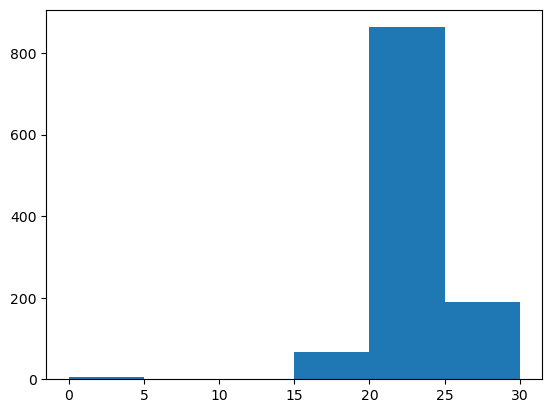

In [19]:
bins = np.arange(0, 35, 5)
plt.hist(flights[relative_diff_higher_outliers & ET_less_30_min]['CRSElapsedTime'], bins = bins)
plt.show()

In [20]:
# Filtering the flights with Elapsed time between 15 and 20 minutes, which relative difference of ETs is high
pd.set_option('display.max_rows', 70)
pd.set_option('display.width', 120)
print(flights[relative_diff_higher_outliers & (15 < flights['CRSElapsedTime']) & 
              (flights['CRSElapsedTime'] < 20)][rout_info + ['ActualElapsedTime']])
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime
2435800                                65    WRG  PSG 2014-06-08 10:48:00            19.0               30.0
2437272                                65    WRG  PSG 2014-06-09 10:48:00            19.0               25.0
2437750                                65    WRG  PSG 2014-06-10 10:48:00            19.0               24.0
2438131                                65    WRG  PSG 2014-06-15 10:48:00            19.0               23.0
2443225                                65    WRG  PSG 2014-06-14 10:48:00            19.0               31.0
2935878                                65    WRG  PSG 2014-07-01 10:48:00            19.0               23.0
2939064                                65    WRG  PSG 2014-07-04 10:48:00            19.0               24.0
3004362                                65    WRG  PSG 2014-07-06 10:49:00            19.0               23.0
3100525            

These flights look like delayed normal short flights 

In [21]:
# Filtering the flights with Elapsed time less than 15, which relative difference of ETs is high
flights[relative_diff_higher_outliers & (flights['CRSElapsedTime'] < 15)][rout_info + ['ActualElapsedTime']]

,Flight_Number_Reporting_Airline,Origin,Dest,CRSDepDT,CRSElapsedTime,ActualElapsedTime
18294052,5035,FWA,ORD,2017-03-29 19:24:00,4.0,67.0
19335470,7410,DTW,CIU,2017-05-22 15:10:00,1.0,83.0
26019611,5132,SLN,HYS,2018-06-02 17:10:00,5.0,42.0
26634021,5903,MTJ,DFW,2018-07-10 12:27:00,1.0,182.0
26989871,4493,MSP,LGA,2018-07-04 07:09:00,1.0,174.0
27319025,5123,CLT,PGV,2018-08-19 22:25:00,1.0,66.0


And these flights seem very strange due to extreemly short scheduled elapsed times. I'm goitng to drop them

In [22]:
flights = flights[~(relative_diff_higher_outliers & (flights['CRSElapsedTime'] < 15))]

In [23]:
outlier_limit_low, outlier_limit_high = get_outliers_range(flights['RelElapTimeDiff'])

# Filtering flights that had actual elapsed time too short or lond relative to their scheduled time
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_higher_outliers = (flights['RelElapTimeDiff'] > outlier_limit_high)
outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

In [24]:
# Printing some summary for ALL OUTLIERS
print('In 2014-2018 there were {:,d} flights with relative ET difference out of range ({:.2%}, {:+.2%}%), which represent {:.2%} of total flights'
      .format(n:=flights[outliers]['Flight_Number_Reporting_Airline'].count(), 
              outlier_limit_low, 
              outlier_limit_high, 
              n / len(flights)))

In 2014-2018 there were 1,389,106 flights with relative ET difference out of range (-25.23%, +16.66%%), which represent 4.61% of total flights


In [25]:
pd.set_option('display.width', 200)
# Printing the TOP-10 fasterst flights
print(flights[relative_diff_low_outliers][rout_info + ['ActualElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'diff_CRS', 'diff_Act']]
      .sort_values('RelElapTimeDiff', ascending=True))
print()
pd.reset_option('display.width')

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime  ElapsedTimeDiff  RelElapTimeDiff  diff_CRS  diff_Act
21568647                             5028    SBP  SFO 2017-10-09 08:55:00           302.0               52.0           -250.0        -0.827637       0.0       0.0
27060967                             5132    SLN  HYS 2018-07-17 05:40:00           161.0               44.0           -117.0        -0.726562       0.0       0.0
10814398                              969    SAN  SFO 2015-11-03 20:15:00           285.0               84.0           -201.0        -0.705078       0.0       0.0
23159729                             4656    RDM  MFR 2018-01-07 11:10:00           137.0               41.0            -96.0        -0.700684     -60.0       0.0
24184719                             4528    MKE  DTW 2018-03-29 05:27:00           253.0               76.0           -177.0        -0.699707       0.0       0.0
...                   

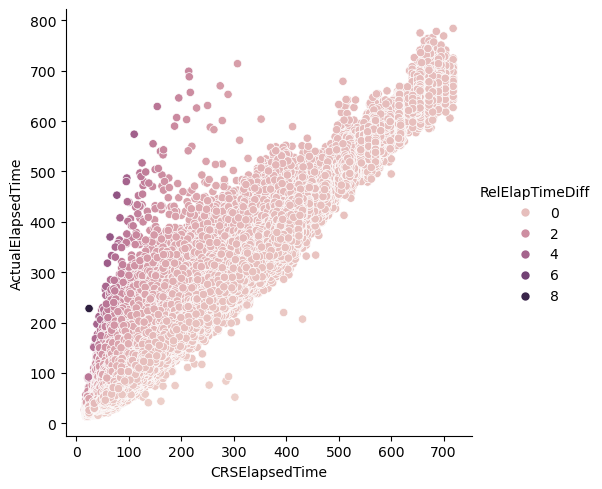

In [64]:
sns.relplot(data=flights,
            x='CRSElapsedTime', 
            y='ActualElapsedTime',
            hue='RelElapTimeDiff',
            kind='scatter')
plt.show()

In [26]:
print(flights[relative_diff_low_outliers].groupby(['Cancelled', 'Diverted'])['Flight_Number_Reporting_Airline'].agg('count'))

Cancelled  Diverted
False      False       263661
Name: Flight_Number_Reporting_Airline, dtype: int64


In [27]:
print(len(flights[relative_diff_low_outliers]))
print(flights[relative_diff_low_outliers]['Cancelled'].sum())
print(flights[relative_diff_low_outliers]['Diverted'].sum())

263661
0
0


In [28]:
print(flights[relative_diff_higher_outliers].groupby(['Cancelled', 'Diverted'])['Flight_Number_Reporting_Airline'].agg('count'))

Cancelled  Diverted
False      False       1125445
Name: Flight_Number_Reporting_Airline, dtype: int64


In [29]:
print(len(flights[relative_diff_higher_outliers]))
print(flights[relative_diff_higher_outliers]['Cancelled'].sum())
print(flights[relative_diff_higher_outliers]['Diverted'].sum())

1125445
0
0


In [30]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30144604 entries, 0 to 30144614
Data columns (total 38 columns):
 #   Column                           Dtype                  
---  ------                           -----                  
 0   Reporting_Airline                category               
 1   Flight_Number_Reporting_Airline  int16                  
 2   Origin                           category               
 3   Dest                             category               
 4   DepDelay                         float16                
 5   DepartureDelayGroups             category               
 6   DepTimeBlk                       category               
 7   ArrDelay                         float16                
 8   ArrivalDelayGroups               category               
 9   ArrTimeBlk                       category               
 10  Cancelled                        bool                   
 11  CancellationCode                 category               
 12  Diverted         

In [31]:
flights[flights['DivReachedDest']][['ArrDT', 'ArrDelay', 'DivArrDelay']].head(10)

,ArrDT,ArrDelay,DivArrDelay
2937,2014-01-27 20:53:00,NaN,115.0
3147,2014-01-27 20:46:00,NaN,626.0
3492,2014-01-25 19:31:00,NaN,227.0
5187,2014-01-28 01:59:00,NaN,338.0
6040,2014-01-28 20:33:00,NaN,193.0
6885,2014-01-28 02:04:00,NaN,135.0
7758,2014-01-29 22:25:00,NaN,137.0
9181,2014-01-30 15:30:00,NaN,280.0
11361,2014-01-31 04:52:00,NaN,467.0
11876,2014-01-30 23:28:00,NaN,345.0


In [32]:
flights[flights['DivReachedDest'] & ~flights['ArrDelay'].isna()][['ArrDT', 'ArrDelay', 'DivArrDelay']].head(10)

,ArrDT,ArrDelay,DivArrDelay


In [33]:
del(flights)

In [34]:
del(relative_diff_higher_outliers, relative_diff_low_outliers, outliers)